# Klarna task

Tools to be used.
- Sklearn for preprocessing.
- Sagemaker Linear Learner for inference.

In [1]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

In [2]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
prefix = 'sagemaker-sklearn-linearlearner'
my_region = boto3.session.Session().region_name # set the region of the instance

In [3]:
my_region

'us-east-2'

In [38]:
bucket_name = 'task-bucket-2021'
s3 = boto3.client('s3')

s3.download_file(bucket_name, 'data/dataset.csv', '../data/dataset.csv')

In [4]:
data_df = pd.read_csv('../data/dataset.csv', sep=';', na_values='NA')
data_df.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [5]:
pd.set_option('display.max_columns', 100)

In [6]:
data_df.describe()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
count,89976.000000,9.997600e+04,88140.000000,88140.000000,88140.000000,40661.000000,45603.000000,45603.000000,33215.000000,42274.000000,39626.000000,99976.000000,76140.000000,50671.000000,99976.000000,99976.000000,77037.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,81898.000000,81898.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,9.997600e+04,99976.000000,30461.000000
mean,0.014315,1.225515e+04,0.223043,5.044622,0.286896,1.331292,1.042168,1.172905,1.337348,1.185291,1.253142,36.016284,17.971473,14.989786,9203.654217,11215.120819,0.114840,0.599404,0.061745,0.059364,7.275826,6.369799,0.469443,0.000122,0.000159,2.141564,0.923202,0.827519,0.744299,0.800582,1.052233,1.226164,4.035429,10816.065386,6542.895325,3.920880e+04,15.329780,1.121762
std,0.118786,3.548148e+04,5.808117,22.863971,2.929910,26.482299,0.202713,0.420142,0.575043,0.443309,0.505559,13.001306,12.751066,10.297420,13512.167229,15256.414937,0.293483,1.550026,0.374691,0.366224,16.030369,15.350244,1.360349,0.011049,0.014407,6.300978,0.569530,0.622812,0.634912,0.719946,0.786121,0.833502,163.934564,26463.972170,19041.223585,9.064929e+04,5.031360,0.343660
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278,1.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,10.800000,8.400000,2000.000000,3350.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.600000e+03,11.622708,1.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.152082,1.000000,1.000000,1.000000,1.000000,1.000000,34.000000,14.909091,13.000000,6052.000000,7580.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.599500e+04,15.792778,1.000000
75%,0.000000,4.937250e+03,0.000000,0.000000,0.000000,0.662952,1.000000,1.000000,2.000000,1.000000,1.000000,45.000000,21.000000,18.285714,11380.000000,13783.000000,0.100000,1.000000,0.000000,0.000000,7.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9029.750000,85.000000,4.384425e+04,19.542014,1.000000
max,1.000000,1.128775e+06,365.000000,365.000000,97.000000,3914.000000,4.000000,4.000000,4.000000,4.000000,4.000000,100.000000,260.000000,87.000000,279000.000000,538500.000000,9.000000,47.000000,17.000000,13.000000,261.000000,313.000000,42.000000,1.000000,2.000000,182.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722,3.000000


## Observations

- The label *default* is imbalance.
- The magnitude of the values varies considerably from variable to variable.
- There are NaNs in both numeric and categorical variables.

In [11]:
train_test_df = data_df[data_df['default'].notna()]

submit_df = data_df[data_df['default'].isna()]
submit_df = submit_df.drop(columns='default')

In [12]:
data_df.shape, train_test_df.shape, submit_df.shape

((99976, 43), (89976, 43), (10000, 42))

In [13]:
data_df.nunique()

uuid                                   99976
default                                    2
account_amount_added_12_24m            23721
account_days_in_dc_12_24m                127
account_days_in_rem_12_24m               282
account_days_in_term_12_24m               64
account_incoming_debt_vs_paid_0_24m    23674
account_status                             4
account_worst_status_0_3m                  4
account_worst_status_12_24m                4
account_worst_status_3_6m                  4
account_worst_status_6_12m                 4
age                                       79
avg_payment_span_0_12m                  7939
avg_payment_span_0_3m                   2256
merchant_category                         57
merchant_group                            12
has_paid                                   2
max_paid_inv_0_12m                     12497
max_paid_inv_0_24m                     12932
name_in_email                              8
num_active_div_by_paid_inv_0_12m         861
num_active

In [14]:
data_df.dtypes

uuid                                    object
default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                         float64
account_worst_status_0_3m              float64
account_worst_status_12_24m            float64
account_worst_status_3_6m              float64
account_worst_status_6_12m             float64
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                  bool
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_di

### There is no easy way to distinguish numeric and categorial. The below is a manual definition.

In [15]:
label = 'default'

variables = [x for x in data_df.columns if x != 'uuid' and x != label]

numeric_cols = [
    'account_amount_added_12_24m',
    'account_days_in_dc_12_24m',
    'account_days_in_rem_12_24m',
    'account_days_in_term_12_24m',
    'account_incoming_debt_vs_paid_0_24m',
    'age',
    'avg_payment_span_0_12m',
    'avg_payment_span_0_3m',
    'max_paid_inv_0_12m',
    'max_paid_inv_0_24m',
    'num_active_div_by_paid_inv_0_12m',
    'num_active_inv',
    'num_arch_dc_0_12m',
    'num_arch_dc_12_24m',
    'num_arch_ok_0_12m',
    'num_arch_ok_12_24m',
    'num_arch_rem_0_12m',
    'num_arch_written_off_0_12m',
    'num_arch_written_off_12_24m',
    'num_unpaid_bills',
    'recovery_debt',
    'sum_capital_paid_account_0_12m',
    'sum_capital_paid_account_12_24m',
    'sum_paid_inv_0_12m',
    'time_hours'    
]

categorical_cols = [x for x in variables if x not in numeric_cols]

In [16]:
len(variables), len(numeric_cols), len(categorical_cols)

(41, 25, 16)

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_test_df, test_size=0.2)

train.shape, test.shape

((71980, 43), (17996, 43))

## Numeric variables
- First, impute NaNs with median.
- Then, standardize.

## Categorical variables
- First, impute NaNs with the constant value, -1.
- Then, one-hot encode.

In [18]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=-1),
    OneHotEncoder(handle_unknown="ignore"),
)

In [19]:
std_numeric = numeric_transformer.fit_transform(train[numeric_cols])
std_numeric_df = pd.DataFrame(std_numeric, columns=numeric_cols)
std_numeric_df.head()

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
0,-0.351707,-0.036836,-0.207493,-0.091118,-0.041017,-1.154378,-0.206101,-0.136089,-0.682776,-0.736697,-0.337878,-0.386939,-0.162747,-0.162337,-0.452861,-0.419462,-0.347948,-0.009862,-0.010115,-0.335510,-0.032448,-0.408852,-0.342642,-0.440427,-1.668705
1,0.036008,-0.036836,-0.207493,-0.091118,-0.056128,0.076435,1.816457,3.735293,0.099894,-0.018692,-0.337878,-0.386939,2.457950,-0.162337,-0.329312,-0.354022,3.392610,-0.009862,-0.010115,-0.179222,-0.032448,0.248689,4.511306,0.056087,0.000746
2,0.369342,-0.036836,-0.207493,-0.091118,-0.056129,2.076506,-0.850247,-1.019035,0.260276,0.619826,-0.337878,-0.386939,-0.162747,-0.162337,-0.267537,-0.288581,-0.347948,-0.009862,-0.010115,-0.335510,-0.032448,0.534117,-0.342642,-0.127934,-0.211972
3,0.902058,-0.036836,-0.207493,-0.091118,-0.049516,-0.923600,0.289957,0.611020,0.177076,0.023679,-0.337878,-0.386939,-0.162747,-0.162337,0.473761,0.758468,0.400164,-0.009862,-0.010115,-0.022933,-0.032448,0.047181,0.217658,0.507505,-0.049825
4,2.398770,-0.036836,-0.207493,-0.091118,-0.013723,-0.308194,-0.076861,1.086453,1.228213,1.052666,-0.183873,0.258363,-0.162747,-0.162337,0.967959,1.412873,-0.347948,-0.009862,-0.010115,0.602222,-0.032448,0.183703,5.533239,2.492831,0.068597


In [95]:
std_numeric_df.describe()

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
count,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04,7.198000e+04
mean,4.353068e-16,-7.224958e-16,-1.628891e-15,-3.501016e-16,-1.535928e-15,2.217022e-16,-8.331284e-16,1.549828e-15,5.713580e-16,1.045866e-16,-6.037836e-16,9.917355e-16,2.864487e-15,2.796835e-16,4.619435e-15,-1.028203e-15,-4.931344e-15,1.152929e-15,8.220127e-16,-6.654999e-16,1.653260e-15,1.615826e-15,3.285871e-15,-8.944309e-16,3.695294e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-3.457486e-01,-3.732821e-02,-2.085824e-01,-9.373517e-02,-3.471175e-02,-1.384370e+00,-1.530400e+00,-1.894744e+00,-6.804637e-01,-7.370307e-01,-3.344974e-01,-3.893441e-01,-1.675084e-01,-1.630191e-01,-4.540431e-01,-4.128418e-01,-3.432003e-01,-9.130358e-03,-1.011492e-02,-3.415009e-01,-2.378039e-02,-4.099052e-01,-3.425473e-01,-4.350909e-01,-3.051975e+00
25%,-3.457486e-01,-3.732821e-02,-2.085824e-01,-9.373517e-02,-2.666270e-02,-8.452224e-01,-4.475143e-01,-1.364834e-01,-5.329978e-01,-5.184140e-01,-3.344974e-01,-3.893441e-01,-1.675084e-01,-1.630191e-01,-4.540431e-01,-4.128418e-01,-3.432003e-01,-9.130358e-03,-1.011492e-02,-3.415009e-01,-2.378039e-02,-4.099052e-01,-3.425473e-01,-4.058090e-01,-7.364943e-01
50%,-3.457486e-01,-3.732821e-02,-2.085824e-01,-9.373517e-02,-2.666270e-02,-1.520326e-01,-2.088455e-01,-1.364834e-01,-2.330890e-01,-2.405614e-01,-3.344974e-01,-3.893441e-01,-1.675084e-01,-1.630191e-01,-3.298007e-01,-2.835678e-01,-3.432003e-01,-9.130358e-03,-1.011492e-02,-3.415009e-01,-2.378039e-02,-4.099052e-01,-3.425473e-01,-2.583328e-01,9.212363e-02
75%,-2.065396e-01,-3.732821e-02,-2.085824e-01,-9.373517e-02,-2.666270e-02,6.951993e-01,1.210949e-01,-1.026707e-01,1.589859e-01,1.681995e-01,-1.453942e-01,2.604052e-01,-1.675084e-01,-1.630191e-01,-1.919474e-02,-2.501968e-02,-3.432003e-01,-9.130358e-03,-1.011492e-02,-2.369421e-02,-2.378039e-02,-6.282798e-02,-3.330413e-01,5.212932e-02,8.373242e-01
max,3.106096e+01,6.722769e+01,1.671405e+01,3.424334e+01,2.048018e+02,4.931359e+00,2.154749e+01,9.736826e+00,1.989103e+01,1.752466e+01,3.370408e+01,2.430113e+01,4.362728e+01,2.976400e+01,1.575959e+01,1.981854e+01,3.046838e+01,1.095247e+02,1.617837e+02,2.857891e+01,2.166849e+02,2.101495e+01,1.695162e+01,3.230710e+01,1.724097e+00


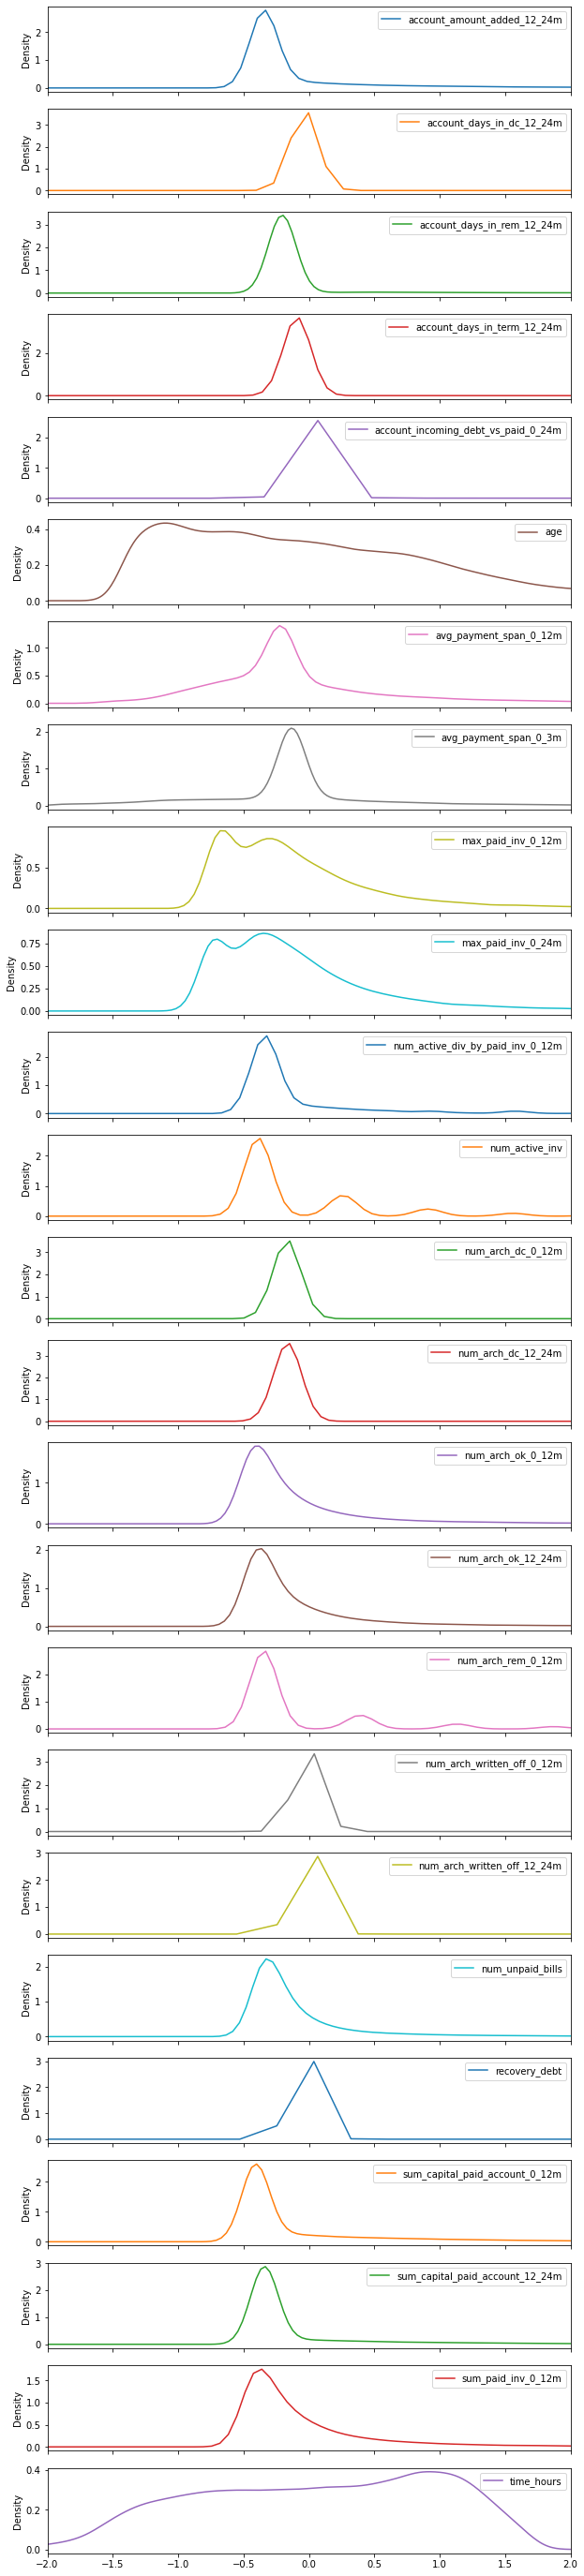

In [31]:
std_numeric_df.plot(kind='density', subplots=True, figsize=(10,50), xlim=(-2,2), sharex=True);

### Some variables are not similar with the normal distribution. Try the Yeo-Johanson transformation to get normal-like distribution.

In [96]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

norm_numeric = pt.fit_transform(std_numeric)
norm_numeric_df = pd.DataFrame(norm_numeric, columns=numeric_cols)
norm_numeric_df.head()

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
0,-0.585661,-0.05212,-0.322436,-0.112271,-0.169764,-0.758959,-0.465523,-1.043262,0.442694,0.183516,-0.598279,-0.656521,-0.211322,-0.204854,0.421084,0.117014,-0.548494,-0.00913,-0.010543,-0.848122,-0.047641,-0.652805,-0.548247,0.346496,1.474474
1,2.065629,-0.05212,-0.322436,-0.112271,2.049013,-0.351661,0.396281,0.219882,0.725393,0.593940,1.710769,1.316582,-0.211322,-0.204854,0.614150,0.944608,-0.548494,-0.00913,-0.010543,2.061381,-0.047641,1.927017,2.123652,0.185705,0.861325
2,-0.585661,-0.05212,-0.322436,-0.112271,-1.229911,0.181163,0.011294,0.522636,1.867011,1.728535,0.645931,1.316582,-0.211322,-0.204854,1.693435,1.274520,-0.548494,-0.00913,-0.010543,0.198884,-0.047641,0.370718,-0.548247,1.929780,-2.017045
3,-0.585661,-0.05212,-0.322436,-0.112271,-0.169764,-0.351661,0.008947,0.046609,-1.367372,-1.473203,-0.598279,-0.656521,-0.211322,-0.204854,-1.076258,-0.958318,-0.548494,-0.00913,-0.010543,-0.848122,-0.047641,-0.652805,-0.548247,-1.146124,1.029686
4,-0.585661,-0.05212,-0.322436,-0.112271,-0.169764,-1.438465,0.718996,-0.142153,0.337057,0.077139,1.941060,1.694768,-0.211322,-0.204854,0.196748,1.073751,1.717257,-0.00913,-0.010543,1.242868,-0.047641,-0.652805,-0.548247,0.631698,-0.632053


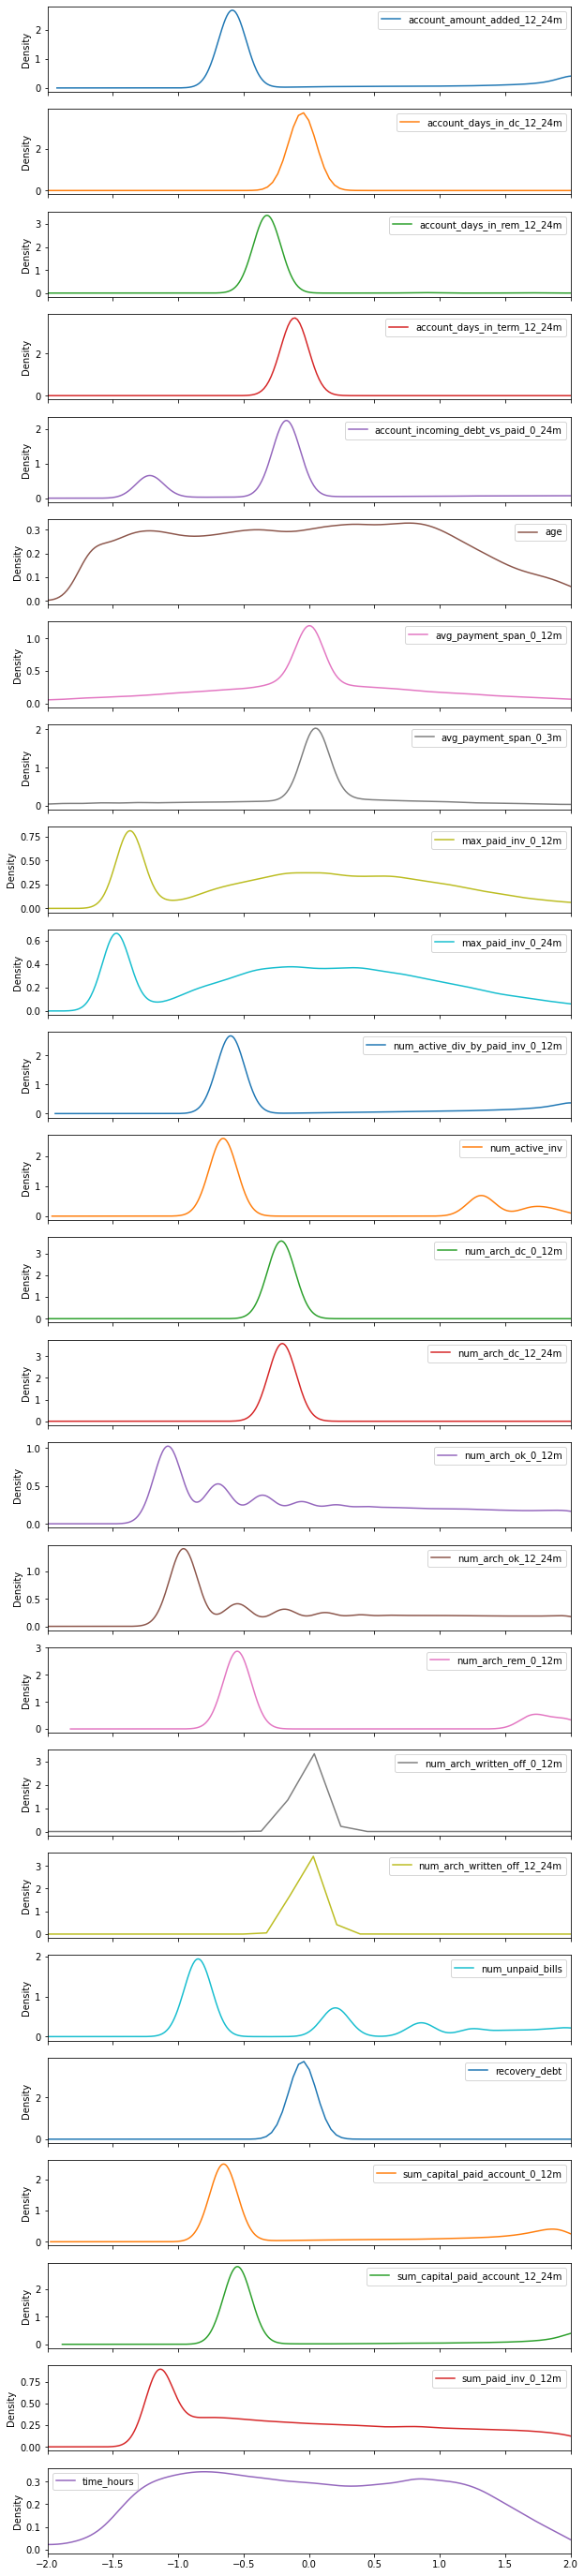

In [35]:
norm_numeric_df.plot(kind='density', subplots=True, figsize=(10,50), xlim=(-2,2), sharex=True);

### Not so effective..

In [20]:
preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_cols),
            ("categorical", categorical_transformer, categorical_cols),
        ]
    )

In [21]:
train_X, train_y = train[variables], train[label].values

In [51]:
transformed_train_X = preprocessor.fit_transform(train_X)

In [52]:
transformed_train_X.shape

(71980, 162)

### Save the first training data.

In [53]:
transformed_train_X = transformed_train_X.toarray().astype('float32')
train_y = train_y.astype('float32')

In [109]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, transformed_train_X, train_y)
buf.seek(0)

0

In [111]:
key = "recordio-train-data"
boto3.resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket_name}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://task-bucket-2021/sagemaker-sklearn-linearlearner/train/recordio-train-data


# The first trial of Linear Learner

In [112]:
from sagemaker.image_uris import retrieve

ll_image = retrieve("linear-learner", boto3.Session().region_name)

In [125]:
# Based on https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_inference_pipeline/Inference%20Pipeline%20with%20Scikit-learn%20and%20Linear%20Learner.ipynb

s3_ll_output_key_prefix = "ll_training_output"
s3_ll_output_location = "s3://{}/{}/{}/{}".format(
    bucket_name, prefix, s3_ll_output_key_prefix, "ll_model"
)

ll_estimator = sagemaker.estimator.Estimator(
    ll_image,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    volume_size=5,
    max_run=3600,
    input_mode="File",
    output_path=s3_ll_output_location,
    sagemaker_session=sagemaker_session,
)

ll_estimator.set_hyperparameters(predictor_type="binary_classifier", feature_dim=transformed_train_X.shape[1], wd=1.0) # To reduce overfitting due to multicollinearity, set L2 regularization.

data_channels = {"train": s3_train_data}
ll_estimator.fit(inputs=data_channels, logs=True)

2021-07-14 09:37:58 Starting - Starting the training job...
2021-07-14 09:38:21 Starting - Launching requested ML instancesProfilerReport-1626255478: InProgress
......
2021-07-14 09:39:21 Starting - Preparing the instances for training.........
2021-07-14 09:40:57 Downloading - Downloading input data
2021-07-14 09:40:57 Training - Downloading the training image...
2021-07-14 09:41:22 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/14/2021 09:41:26 INFO 140175975290688] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 

In [126]:
ll_predictor = ll_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------------!

In [127]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

ll_predictor.serializer = CSVSerializer()
ll_predictor.deserializer = JSONDeserializer()

In [43]:
test_X, test_y = test[variables], test[label].values
transformed_test_X = preprocessor.transform(test_X)
transformed_test_X = transformed_test_X.toarray()

In [129]:
predictions = []
for array in np.array_split(transformed_test_X, 100):
    result = ll_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

In [130]:
from sklearn.metrics import classification_report

print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17765
         1.0       0.35      0.03      0.06       231

    accuracy                           0.99     17996
   macro avg       0.67      0.51      0.52     17996
weighted avg       0.98      0.99      0.98     17996



### As expected, recall of default prediction is very low.


# The second trial
Look into [the linear learner document](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html),
we have a parameter called *positive_example_weight_mult* which is the weight assigned to positive examples when training a binary classifier.

Next, try to turn-on the *positive_example_weight_mult*.

In [143]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_y), train_y)
class_weights

array([ 0.50745174, 34.04919584])

In [144]:
ll_estimator.set_hyperparameters(predictor_type="binary_classifier", feature_dim=transformed_train_X.shape[1], wd=1.0,
                                positive_example_weight_mult="balanced") 

data_channels = {"train": s3_train_data}
ll_estimator.fit(inputs=data_channels, logs=True)

2021-07-14 10:44:58 Starting - Starting the training job...
2021-07-14 10:45:21 Starting - Launching requested ML instancesProfilerReport-1626259498: InProgress
...
2021-07-14 10:45:48 Starting - Preparing the instances for training.........
2021-07-14 10:47:21 Downloading - Downloading input data...
2021-07-14 10:47:41 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/14/2021 10:48:07 INFO 140661165786944] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'au

In [145]:
ll_predictor = ll_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
ll_predictor.serializer = CSVSerializer()
ll_predictor.deserializer = JSONDeserializer()

---------------!

In [146]:
predictions = []
for array in np.array_split(transformed_test_X, 100):
    result = ll_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17765
         1.0       0.25      0.00      0.01       231

    accuracy                           0.99     17996
   macro avg       0.62      0.50      0.50     17996
weighted avg       0.98      0.99      0.98     17996



### Unfortunately, it does not work well.

# The third trial
Try downsampling.

In [25]:
!pip install imblearn

     |████████████████████████████████| 206 kB 5.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [168]:
sum(train_y)/len(train_y)

0.01468463462072798

In [61]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
train_X_res, train_y_res = rus.fit_resample(transformed_train_X, train_y)

In [170]:
sum(train_y_res)/len(train_y_res), train_X_res.shape, train_y_res.shape

(0.2, (5285, 162), (5285,))

In [171]:
train_X_res = train_X_res.astype('float32')
train_y_res = train_y_res.astype('float32')

In [172]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_X_res, train_y_res)
buf.seek(0)

0

In [173]:
key_down = "recordio-down-train-data"
boto3.resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train", key_down)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket_name}/{prefix}/train/{key_down}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://task-bucket-2021/sagemaker-sklearn-linearlearner/train/recordio-down-train-data


In [174]:
ll_estimator.set_hyperparameters(predictor_type="binary_classifier", feature_dim=transformed_train_X.shape[1], wd=1.0) 

data_channels = {"train": s3_train_data}
ll_estimator.fit(inputs=data_channels, logs=True)

2021-07-14 11:41:46 Starting - Starting the training job...
2021-07-14 11:42:09 Starting - Launching requested ML instancesProfilerReport-1626262906: InProgress
...
2021-07-14 11:42:39 Starting - Preparing the instances for training.........
2021-07-14 11:44:10 Downloading - Downloading input data...
2021-07-14 11:44:36 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/14/2021 11:45:01 INFO 140586769033024] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'a

In [175]:
ll_predictor = ll_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
ll_predictor.serializer = CSVSerializer()
ll_predictor.deserializer = JSONDeserializer()

-------------!

In [176]:
predictions = []
for array in np.array_split(transformed_test_X, 100):
    result = ll_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     17765
         1.0       0.10      0.47      0.17       231

    accuracy                           0.94     17996
   macro avg       0.55      0.71      0.57     17996
weighted avg       0.98      0.94      0.96     17996



### Recall gets better, but precision is worse. Seems to be a good direction to study further.

## A few improvement ideas

- Finding optimal sampling ratio.
- Try sophisticated sampling methods.

# Missing values
The missing rate significantly differs in some numeric variables such as *avg_payment_span_0_3m*.

In [177]:
default = data_df[data_df['default'] == 1]
not_default = data_df[data_df['default'] == 0]

default[numeric_cols].isna().sum()/len(default[numeric_cols]) - not_default[numeric_cols].isna().sum()/len(not_default[numeric_cols])

account_amount_added_12_24m            0.000000
account_days_in_dc_12_24m             -0.048778
account_days_in_rem_12_24m            -0.048778
account_days_in_term_12_24m           -0.048778
account_incoming_debt_vs_paid_0_24m   -0.149502
age                                    0.000000
avg_payment_span_0_12m                 0.244720
avg_payment_span_0_3m                  0.310087
max_paid_inv_0_12m                     0.000000
max_paid_inv_0_24m                     0.000000
num_active_div_by_paid_inv_0_12m       0.218408
num_active_inv                         0.000000
num_arch_dc_0_12m                      0.000000
num_arch_dc_12_24m                     0.000000
num_arch_ok_0_12m                      0.000000
num_arch_ok_12_24m                     0.000000
num_arch_rem_0_12m                     0.000000
num_arch_written_off_0_12m             0.178483
num_arch_written_off_12_24m            0.178483
num_unpaid_bills                       0.000000
recovery_debt                          0

Use *add_indicator* to add columns indicating the existence of NaN.

In [54]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median", add_indicator=True), StandardScaler())

In [55]:
std_marking_numeric = numeric_transformer.fit_transform(train[numeric_cols])
std_marking_numeric.shape, train[numeric_cols].shape

((71980, 34), (71980, 25))

9 features are added.

# The fourth trial

In [56]:
preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_cols),
            ("categorical", categorical_transformer, categorical_cols),
        ]
    )

In [57]:
train_X, train_y = train[variables], train[label].values
transformed_train_X = preprocessor.fit_transform(train_X)
transformed_train_X.shape

(71980, 171)

In [58]:
transformed_train_X = transformed_train_X.toarray().astype('float32')
train_y = train_y.astype('float32')

In [59]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, transformed_train_X, train_y)
buf.seek(0)

0

In [184]:
key = "recordio-marking-train-data"
boto3.resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket_name}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://task-bucket-2021/sagemaker-sklearn-linearlearner/train/recordio-marking-train-data


In [185]:
ll_estimator.set_hyperparameters(predictor_type="binary_classifier", feature_dim=transformed_train_X.shape[1], wd=1.0) 

data_channels = {"train": s3_train_data}
ll_estimator.fit(inputs=data_channels, logs=True)

2021-07-14 14:50:33 Starting - Starting the training job...
2021-07-14 14:50:56 Starting - Launching requested ML instancesProfilerReport-1626274233: InProgress
...
2021-07-14 14:51:24 Starting - Preparing the instances for training......
2021-07-14 14:52:32 Downloading - Downloading input data...
2021-07-14 14:52:57 Training - Downloading the training image...............
2021-07-14 14:55:34 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/14/2021 14:55:38 INFO 140161390749504] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_

In [186]:
ll_predictor = ll_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
ll_predictor.serializer = CSVSerializer()
ll_predictor.deserializer = JSONDeserializer()

---------------!

In [71]:
test_X, test_y = test[variables], test[label].values
transformed_test_X = preprocessor.transform(test_X)
transformed_test_X = transformed_test_X.toarray()

In [188]:
predictions = []
for array in np.array_split(transformed_test_X, 100):
    result = ll_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17765
         1.0       0.25      0.00      0.01       231

    accuracy                           0.99     17996
   macro avg       0.62      0.50      0.50     17996
weighted avg       0.98      0.99      0.98     17996



### Unfortunately, it does not work well.

# The fifth trial
The NaN marking with downsampling.

In [62]:
rus = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
train_X_res, train_y_res = rus.fit_resample(transformed_train_X, train_y)

In [63]:
train_X_res = train_X_res.astype('float32')
train_y_res = train_y_res.astype('float32')

In [64]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_X_res, train_y_res)
buf.seek(0)

0

In [65]:
key_down = "recordio-marking-down-train-data"
boto3.resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train", key_down)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket_name}/{prefix}/train/{key_down}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://task-bucket-2021/sagemaker-sklearn-linearlearner/train/recordio-marking-down-train-data


In [66]:
ll_estimator.set_hyperparameters(predictor_type="binary_classifier", feature_dim=transformed_train_X.shape[1], wd=1.0) 

data_channels = {"train": s3_train_data}
ll_estimator.fit(inputs=data_channels, logs=True)

2021-07-18 11:36:22 Starting - Starting the training job...
2021-07-18 11:36:23 Starting - Launching requested ML instancesProfilerReport-1626608182: InProgress
......
2021-07-18 11:37:35 Starting - Preparing the instances for training.........
2021-07-18 11:39:24 Downloading - Downloading input data
2021-07-18 11:39:24 Training - Downloading the training image...
2021-07-18 11:39:45 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/18/2021 11:39:50 INFO 139674792294208] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 

In [67]:
ll_predictor = ll_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
ll_predictor.serializer = CSVSerializer()
ll_predictor.deserializer = JSONDeserializer()

-------------!

In [72]:
predictions = []
for array in np.array_split(transformed_test_X, 100):
    result = ll_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97     17729
         1.0       0.12      0.52      0.19       267

    accuracy                           0.93     17996
   macro avg       0.56      0.73      0.58     17996
weighted avg       0.98      0.93      0.95     17996



### A bit better.

# The sixth trial
Try upsampling.

In [32]:
transformed_train_X = transformed_train_X.toarray().astype('float32')
train_y = train_y.astype('float32')

In [33]:
from imblearn.over_sampling import RandomOverSampler 

rus = RandomOverSampler(sampling_strategy=0.25, random_state=42)
train_X_res, train_y_res = rus.fit_resample(transformed_train_X, train_y)

In [34]:
sum(train_y_res)/len(train_y_res), train_X_res.shape, train_y_res.shape

(0.19999323547317865, (88698, 162), (88698,))

In [35]:
train_X_res = train_X_res.astype('float32')
train_y_res = train_y_res.astype('float32')

In [36]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_X_res, train_y_res)
buf.seek(0)

0

In [39]:
key_down = "recordio-up-train-data"
boto3.resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train", key_down)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket_name}/{prefix}/train/{key_down}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://task-bucket-2021/sagemaker-sklearn-linearlearner/train/recordio-up-train-data


In [41]:
from sagemaker.image_uris import retrieve

ll_image = retrieve("linear-learner", boto3.Session().region_name)

In [42]:
s3_ll_output_key_prefix = "ll_training_output"
s3_ll_output_location = "s3://{}/{}/{}/{}".format(
    bucket_name, prefix, s3_ll_output_key_prefix, "ll_model"
)

ll_estimator = sagemaker.estimator.Estimator(
    ll_image,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    volume_size=5,
    max_run=3600,
    input_mode="File",
    output_path=s3_ll_output_location,
    sagemaker_session=sagemaker_session,
)

ll_estimator.set_hyperparameters(predictor_type="binary_classifier", feature_dim=transformed_train_X.shape[1], wd=1.0) # To reduce overfitting due to multicollinearity, set L2 regularization.

data_channels = {"train": s3_train_data}
ll_estimator.fit(inputs=data_channels, logs=True)

2021-07-18 11:18:18 Starting - Starting the training job...
2021-07-18 11:18:19 Starting - Launching requested ML instancesProfilerReport-1626607098: InProgress
...
2021-07-18 11:19:05 Starting - Preparing the instances for training............
2021-07-18 11:21:14 Downloading - Downloading input data
2021-07-18 11:21:14 Training - Downloading the training image...
2021-07-18 11:21:43 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/18/2021 11:21:38 INFO 139886422742848] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': '

In [46]:
ll_predictor = ll_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------------!

In [47]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

ll_predictor.serializer = CSVSerializer()
ll_predictor.deserializer = JSONDeserializer()

In [48]:
predictions = []
for array in np.array_split(transformed_test_X, 100):
    result = ll_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     17729
         1.0       0.05      0.02      0.03       267

    accuracy                           0.98     17996
   macro avg       0.52      0.51      0.51     17996
weighted avg       0.97      0.98      0.98     17996



### Upsampling is counterproductive.

# Summary

| Trial      | Description      | Recall | F1 |
| ----------- | ----------- | ----------- | ----------- |
|1| raw data      | 0.03      | 0.06 |
|2| positive_example_weight_mult="balanced"   | 0.00        |       0.01|
|3| downsampling, 0.25   | 0.47        |            0.17 |
|4| NaN marking   | 0.00 |           0.01 |
|5| **NaN marking with downsampling**  | **0.52**     |  **0.19**|
|6| oversampling, 0.25   |  0.02     | 0.03     |


In [99]:
import io
import sagemaker.amazon.common as smac
from sklearn.model_selection import train_test_split

bucket = 'task-bucket-2021'
s3 = boto3.client('s3')

data_df = pd.read_csv('../data/dataset.csv', sep=';', na_values='NA', )

label = 'default'
variables = [x for x in data_df.columns if x != 'uuid' and x != label]
numeric_cols = [
    'account_amount_added_12_24m',
    'account_days_in_dc_12_24m',
    'account_days_in_rem_12_24m',
    'account_days_in_term_12_24m',
    'account_incoming_debt_vs_paid_0_24m',
    'age',
    'avg_payment_span_0_12m',
    'avg_payment_span_0_3m',
    'max_paid_inv_0_12m',
    'max_paid_inv_0_24m',
    'num_active_div_by_paid_inv_0_12m',
    'num_active_inv',
    'num_arch_dc_0_12m',
    'num_arch_dc_12_24m',
    'num_arch_ok_0_12m',
    'num_arch_ok_12_24m',
    'num_arch_rem_0_12m',
    'num_arch_written_off_0_12m',
    'num_arch_written_off_12_24m',
    'num_unpaid_bills',
    'recovery_debt',
    'sum_capital_paid_account_0_12m',
    'sum_capital_paid_account_12_24m',
    'sum_paid_inv_0_12m',
    'time_hours'    
]
categorical_cols = [x for x in variables if x not in numeric_cols]

data_df[categorical_cols] = pd.Categorical(data_df[categorical_cols]).codes

train_test_df = data_df[data_df[label].notna()]
train, test = train_test_split(train_test_df, test_size=0.2,  random_state=42)

class_0 = train[train[label] == 0]
class_1 = train[train[label] == 1]
down_class_0 = class_0.sample(4*len(class_1), random_state=42) # class_0 : class_1 = 4 : 1

train_down = pd.concat([down_class_0, class_1]).sample(frac=1, random_state=42)
    
submit_df = data_df[data_df[label].isna()]
submit_df = submit_df.drop(columns=label)

def recordio_upload(key, X, y=None):
    buf = io.BytesIO()
    if y is not None:
        smac.write_numpy_to_dense_tensor(buf, X, y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X)
    buf.seek(0)
    boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
    
    return None

recordio_upload(
    'train_full',
    train[variables].values.astype('float64'),
    train[label].values.astype('float64')
)

recordio_upload(
    'train_downsample',
    train_down[variables].values.astype('float64'),
    train_down[label].values.astype('float64')
)

recordio_upload(
    'test',
    test[variables].values.astype('float64'),
    test[label].values.astype('float64')
)

recordio_upload(
    'submit',
    submit_df[variables].values.astype('float64')
)

In [101]:
train_down.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
8154,75a2c1ee-cfab-464e-9bfc-0df749fb4a08,1.0,0,0.0,0.0,0.0,NaN,0,1,2,3,4,18,NaN,NaN,6,7,5,0.0,0.0,8,NaN,0,0,0,0,0,0,NaN,NaN,0,11,9,10,14,12,13,0,0,0,0,10.368611,15
85233,7937b3e9-958b-4366-b3ae-81e992ff631e,1.0,0,0.0,0.0,0.0,NaN,0,1,2,3,4,51,NaN,NaN,6,7,5,0.0,0.0,8,NaN,0,0,0,0,0,0,NaN,NaN,0,11,9,10,14,12,13,0,0,0,0,1.275556,15
11438,0f2e2067-a6b3-485b-bf12-48fefa948dc5,0.0,0,0.0,0.0,0.0,NaN,0,1,2,3,4,25,24.500000,NaN,6,7,5,6455.0,8220.0,8,0.000000,0,0,0,2,2,0,0.0,0.0,0,11,9,10,14,12,13,0,0,0,11930,12.601111,15
18678,07e5440a-e7d8-42eb-a2b0-3378937a48f4,1.0,6195,0.0,20.0,0.0,0.0,0,1,2,3,4,19,33.750000,NaN,6,7,5,6750.0,6750.0,8,0.166667,1,0,2,1,0,3,0.0,0.0,1,11,9,10,14,12,13,0,4898,0,29003,18.514722,15
53312,fb51e02f-cf5c-4547-a741-a2b99aacfaf7,0.0,0,0.0,0.0,0.0,NaN,0,1,2,3,4,29,16.870968,19.666667,6,7,5,14580.0,14580.0,8,0.062500,2,0,0,31,20,0,0.0,0.0,2,11,9,10,14,12,13,0,0,0,93020,14.031111,15


In [118]:
import sys
sys.path.append("..")

from preprocess.preprocess import predict_fn

In [ ]:
predict_fn()